In [1]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
%matplotlib inline
from transformers import AutoTokenizer, AutoModelWithLMHead
import shap
from shap.utils import GenerateLogits
import scipy as sp
import nlp
import torch
import spacy
from shap.utils import assert_import, record_import_error, safe_isinstance, make_masks, OpChain, MaskedModel
from shap import maskers, links

In [2]:
dataset = nlp.load_dataset('xsum',split='train')

WARNING - Using custom data configuration default


In [3]:
def cuda_memory_stats():
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_cached(0)
    a = torch.cuda.memory_allocated(0)
    f = c-a
    print(t)
    print(c)
    print(a)
    print(f)

In [4]:
cuda_memory_stats()

4294967296
0
0
0


torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved


In [5]:
torch.cuda.empty_cache()

In [6]:
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model =  AutoModelWithLMHead.from_pretrained("sshleifer/distilbart-xsum-12-6").cuda()

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.


In [7]:
# Instantiate object of GenerateLogits with model and tokenizer
logit_generator_model = GenerateLogits(model=model,tokenizer=tokenizer)

In [8]:
def f_predict(x):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(x)]).cuda()
    with torch.no_grad():
        out=model.generate(input_ids)
    sentence = [tokenizer.decode(g, skip_special_tokens=True) for g in out][0]
    del input_ids, out
    return sentence

In [9]:
def gen_kwargs(x):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(x)]).cuda()
    with torch.no_grad():
        # generate input ids for output translation which we aim to explain
        out=model.generate(input_ids)
    # slice sentence by removing bos and eos token ids
    target_sentence_ids = out[:,1:-1].cuda()
    output_names = logit_generator_model.get_output_names(target_sentence_ids)
    del out
    return {'target_sentence_ids':target_sentence_ids,'input_ids':input_ids,'output_names':output_names,'fixed_context':1}

In [10]:
# This function defines the additional arguments passed onto the model function required inorder to get conditional logits corresponding to the original input sentence translation
def f_kwargs(x):
    kwargs = gen_kwargs(x)
    return kwargs

In [15]:
def plot_logits(token_ids,sentence_ids,conditional_logits,sentences,batch_args,output_batch,i,fixed_context,clust_matrix,M):
    m00, m10, m01, f00, f11, ind, lind, rind, weight = batch_args[i//2]
    f10, f01 = output_batch[i-1], output_batch[i]
    f10_summary = f_predict(sentences[i-1])
    f01_summary = f_predict(sentences[i])
    f10_highlight_mask, f01_highlight_mask = m10 ^ m00, m01 ^ m00
    f10_highlight = tokenizer.decode(sentence_ids[0,1:-1][f10_highlight_mask[1:-1]])
    f01_highlight = tokenizer.decode(sentence_ids[0,1:-1][f01_highlight_mask[1:-1]])
    f10_highlight_in_context = sentences[i-1].replace(f10_highlight,"\033[1m"+f10_highlight+"\033[0m")
    f01_highlight_in_context = sentences[i].replace(f01_highlight,"\033[1m"+f01_highlight+"\033[0m")
    print(f'\n \033[1mMasked input (f10):\033[0m {f10_highlight_in_context}')
    print(f'\n \033[1mSummary (f10):\033[0m {f10_summary}')
    print(f'\n \033[1mMasked input (f01):\033[0m {f01_highlight_in_context}')
    print(f'\n \033[1mSummary (f01):\033[0m {f01_summary}')
    interaction_effect = (f11 - f10 - f01 + f00) if fixed_context==0 else -(f11 - f10 - f01 + f00)
    main_effect = f11-f00
    group_size = int(clust_matrix[ind-M,3])
    lsize = int(clust_matrix[lind-M,3]) if lind >= M else 1
    rsize = int(clust_matrix[rind-M,3]) if rind >= M else 1
    print(f'\n \033[1mInteraction Effect:\033[0m {interaction_effect}')
    print(f'\n \033[1mMain Effect:\033[0m {main_effect}')
    print(f'\n \033[1mf10 Effect:\033[0m {f10}')
    print(f'\n \033[1mf01 Effect:\033[0m {f01}')
    print(f'\n \033[1mInteraction Effect distribution fraction (f10):\033[0m {lsize / group_size}')
    print(f'\n \033[1mInteraction Effect distribution fraction (f01):\033[0m {rsize / group_size}')
    #print(f'\033[1mProbability:\033[0m')
    mlp.rcParams['figure.figsize']=(12,7)
    token_ids=tokenizer.convert_ids_to_tokens(token_ids[0])
    for i,token in enumerate(token_ids):
        token_ids[i]=token+'_'+str(i)
    if fixed_context==0:
        print(f'\n \033[1mToken Max Affect (f10):\033[0m {token_ids[np.argmax(np.abs(f10 - f00))].replace("Ġ","")}')
        print(f'\n \033[1mToken Max Affect (f01):\033[0m {token_ids[np.argmax(np.abs(f01 - f00))].replace("Ġ","")}')
    else:
        print(f'\n \033[1mToken Max Affect (f10):\033[0m {token_ids[np.argmax(np.abs(f11 - f01))].replace("Ġ","")}')
        print(f'\n \033[1mToken Max Affect (f01):\033[0m {token_ids[np.argmax(np.abs(f11 - f10))].replace("Ġ","")}')
    
    #token_ids_x = [i for i in range(len(token_ids))]
    token_ids = token_ids*4
    scores = f11.tolist() + f10.tolist() + f01.tolist() + f00.tolist()
    perturb_type = ['f11']*len(f11) + ['f10']*len(f10) + ['f01']*len(f01) + ['f00']*len(f00)
    plot_df = pd.DataFrame({'Tokens':token_ids,'Scores':scores,'Perturb_type':perturb_type})
    bar = sns.barplot(data=plot_df, x="Tokens", hue="Perturb_type", y="Scores", edgecolor="white")
    plt.xticks(rotation=90)
    plt.show()

In [16]:
def f(x_batch,**kwargs):
    output_batch=[]
    # Extract target sentence for which we want to generate conditional logits
    target_sentence_ids=kwargs['target_sentence_ids']
    sentence_ids = kwargs['input_ids']
    batch_args=None
    if 'batch_args' in kwargs:
        batch_args = kwargs['batch_args']
    for i,source_sentence in enumerate(x_batch):
        conditional_logits = logit_generator_model.generate_logits(source_sentence,target_sentence_ids)
        output_batch.append(conditional_logits)
        if batch_args is not None and i>0 and i%2!=0:
            plot_logits(target_sentence_ids,sentence_ids,conditional_logits,x_batch,batch_args,output_batch,i,kwargs['fixed_context'],kwargs['clust_mastrix'],kwargs['M'])
    return np.array(output_batch)

In [17]:
explainer = shap.Explainer(f,tokenizer)
explainer.masker.mask_token_id=None
explainer.masker.mask_token=""

explainers.Partition is still in an alpha state, so use with caution...



 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads.

 Summary (f10): Sony has said that a fault in one of its PlayStation 3 games is causing some players to lose control of their consoles.

 Masked input (f01):  "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayS

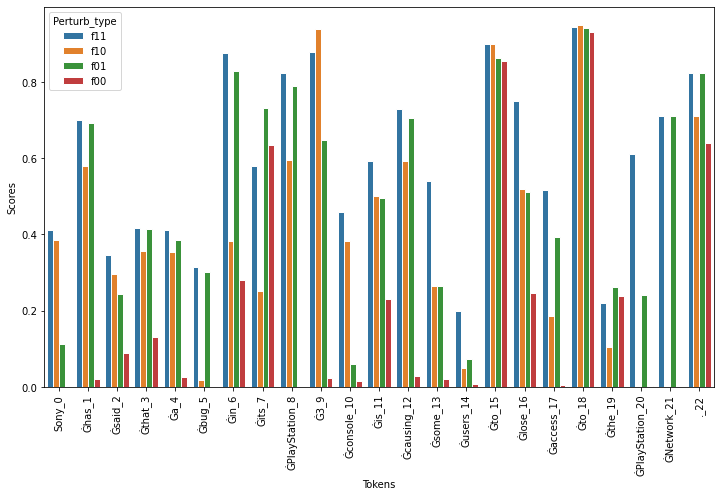


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies,

 Summary (f10): Sony has said that a problem with its PlayStation 3 console is causing some games to go offline.

 Masked input (f01): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year

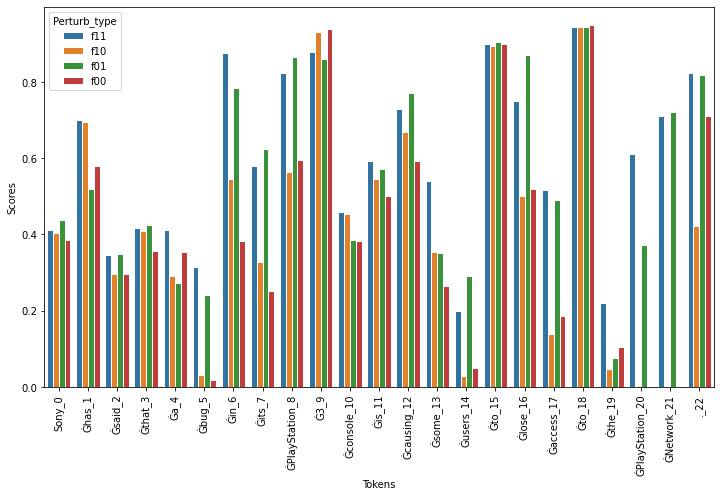


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary (f10): Sony has warned people using older versions of its PlayStation 3 that they may not be able to log on to the PlayStation Network.

 Masked input (f01): Sony have a

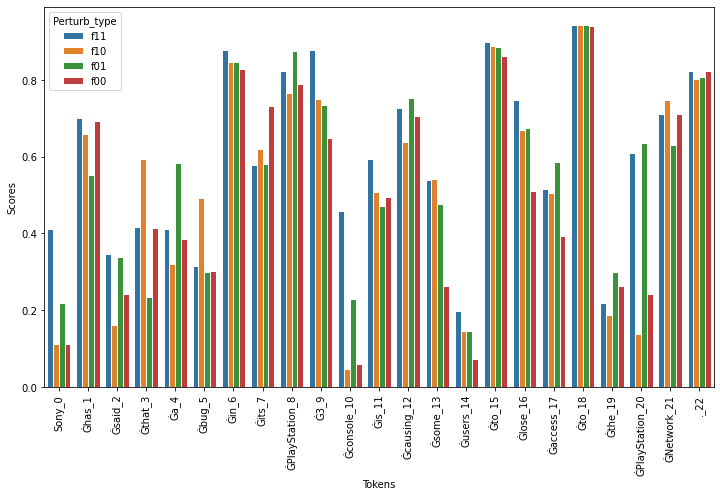


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.

 Summary (f10): Sony has said that a bug in its PlayStation 3 console is causing some players to

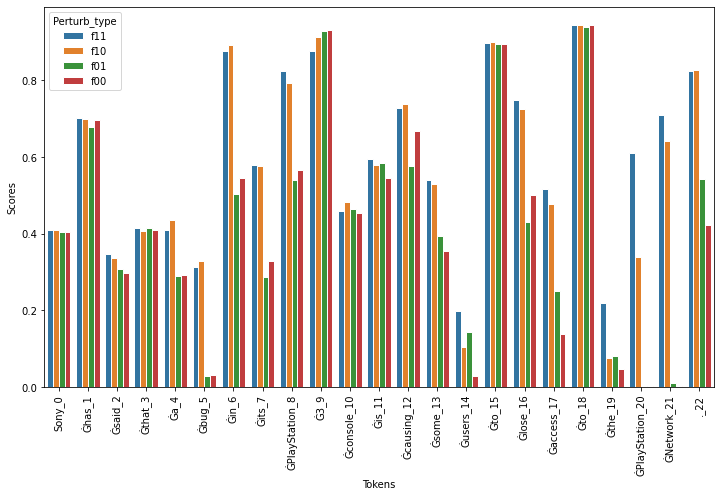


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary (f10): Sony has warned people using older versions of its PlayStation 3 that they ma

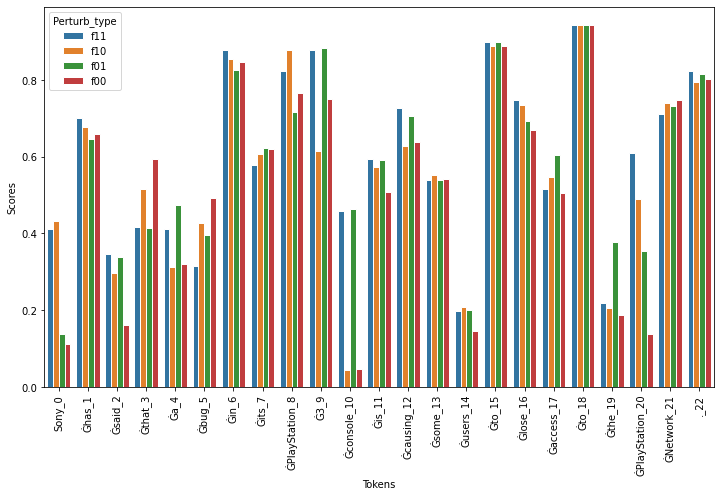


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary (f10): Sony has said that a bug in its PlayStation 3 console is causing some users to 

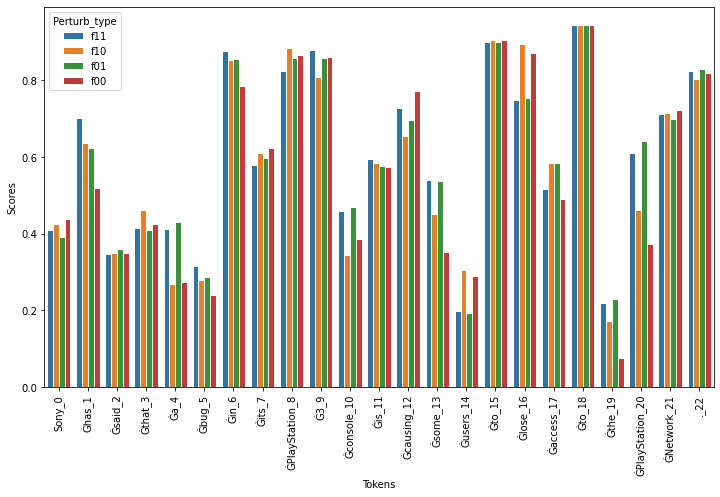


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that thisIt allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary (f10): Sony has said it is investigating a problem with its PlayStation 3 console.

 Masked input (f01): T

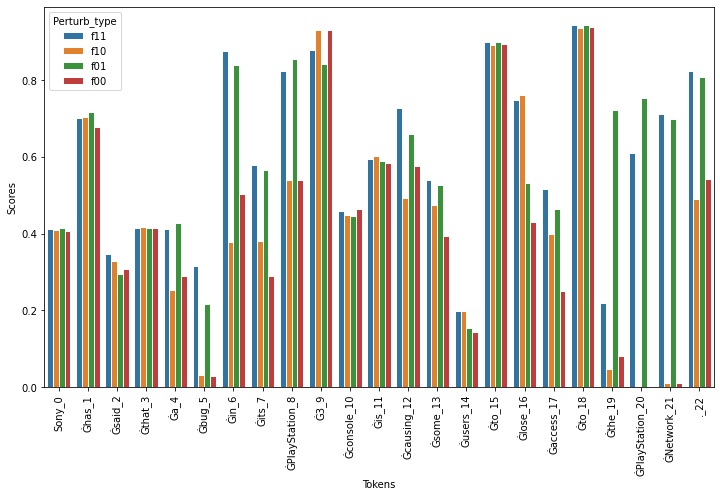


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary (f10)

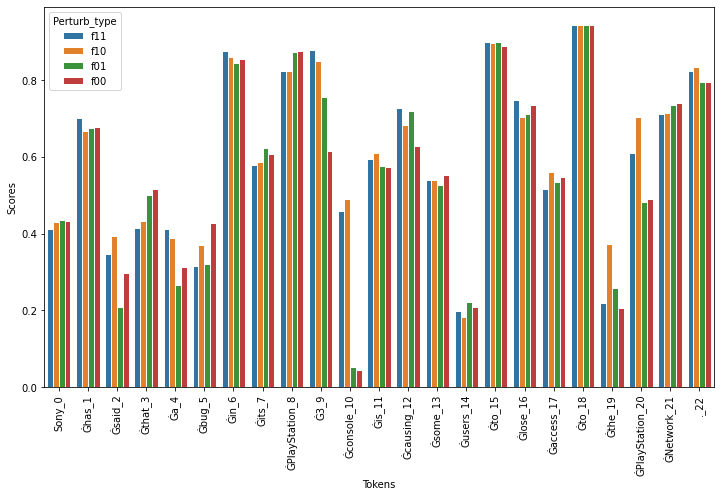


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 S

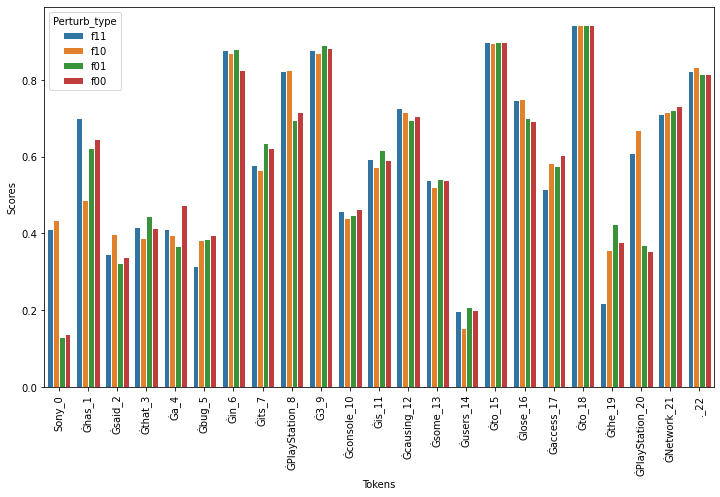


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary (f10): Sony has s

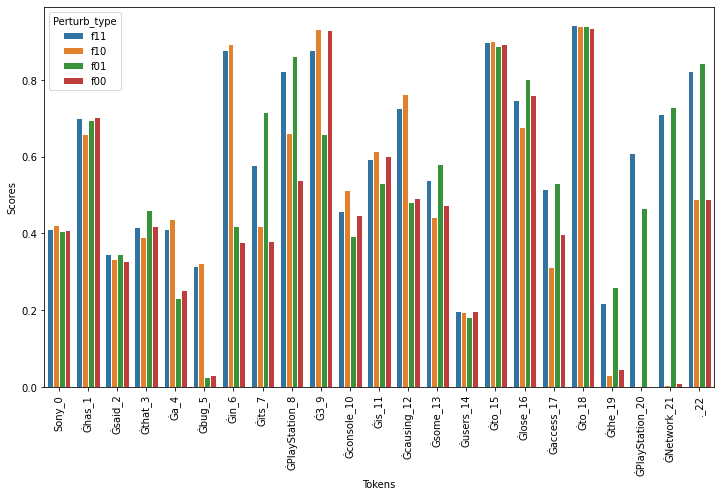


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores

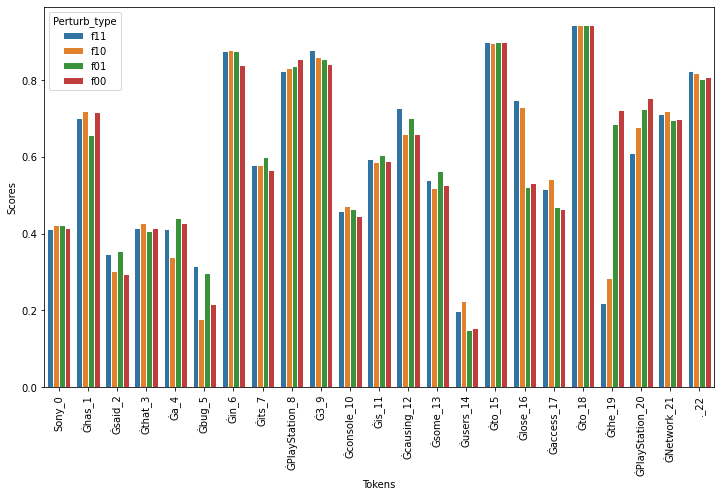


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online 

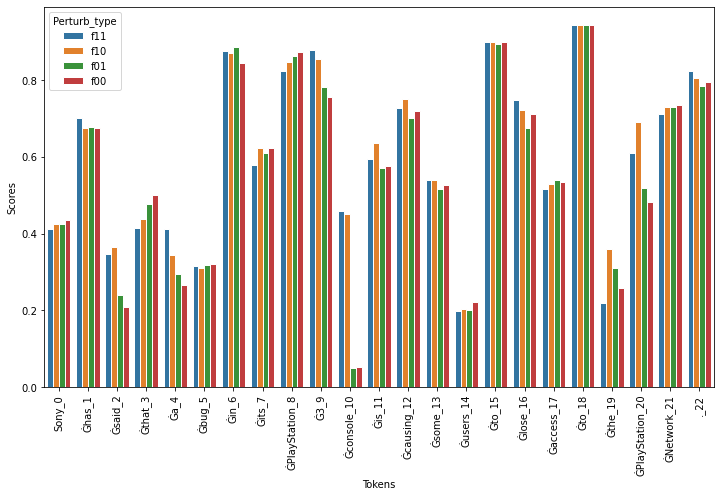


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions ofIt allows users to play their friends at games like Fifa over the internet and also do things like download software or vis

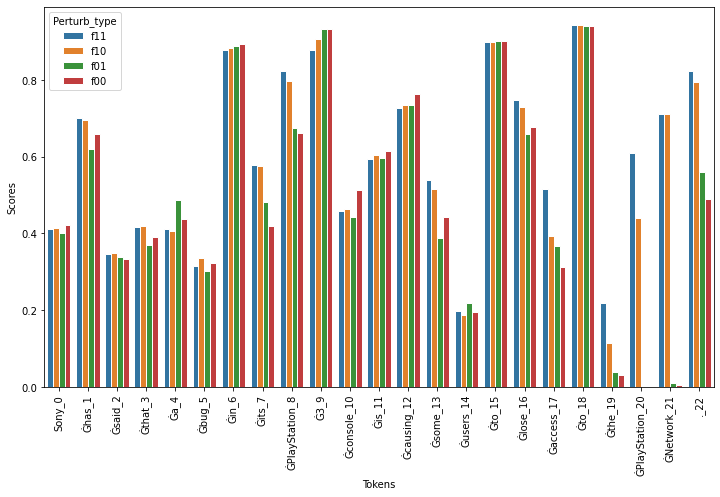


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or vi

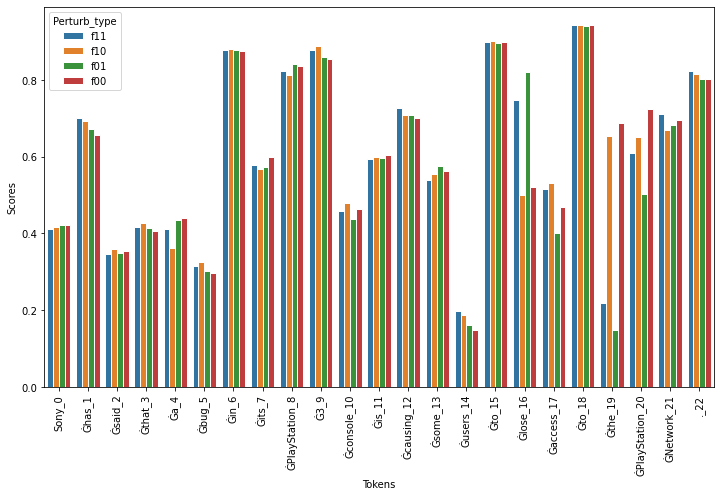


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug inThe PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or visit online stores.


 Summary

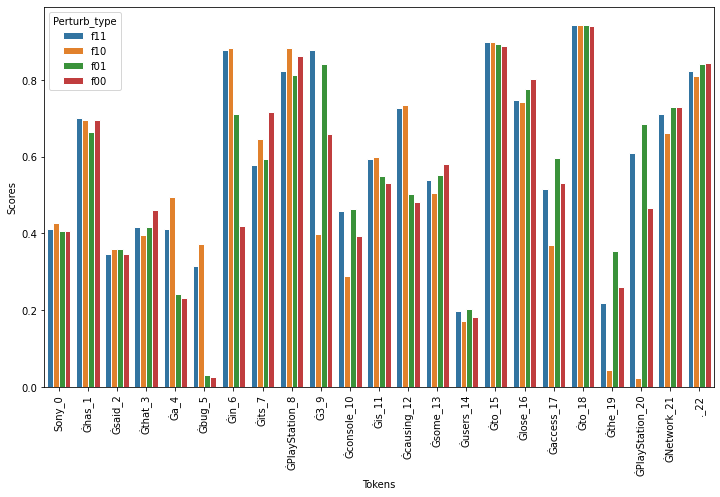


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software o

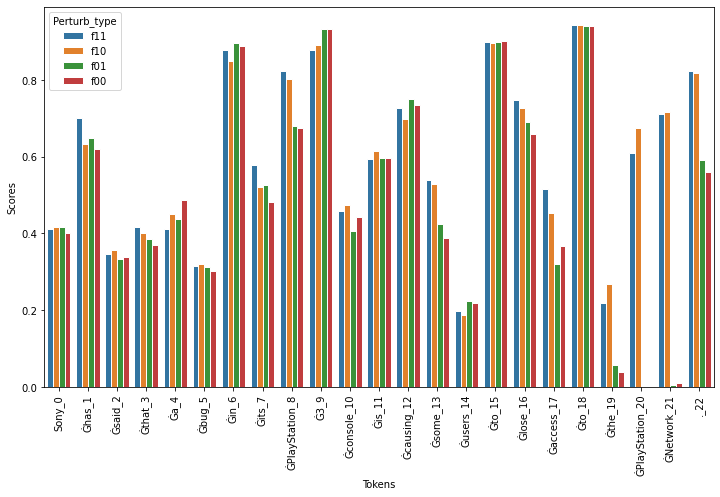


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporatedThe PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download softwa

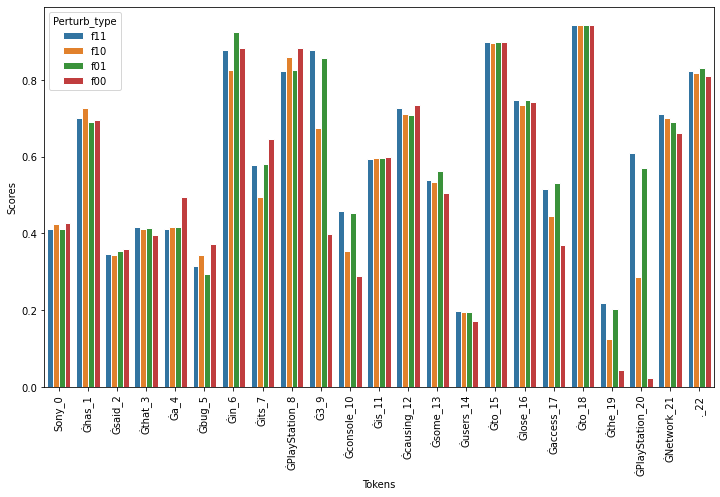


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download sof

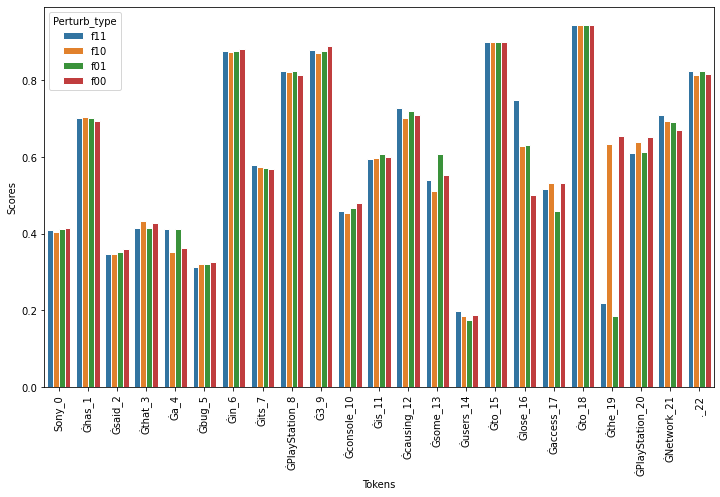


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download s

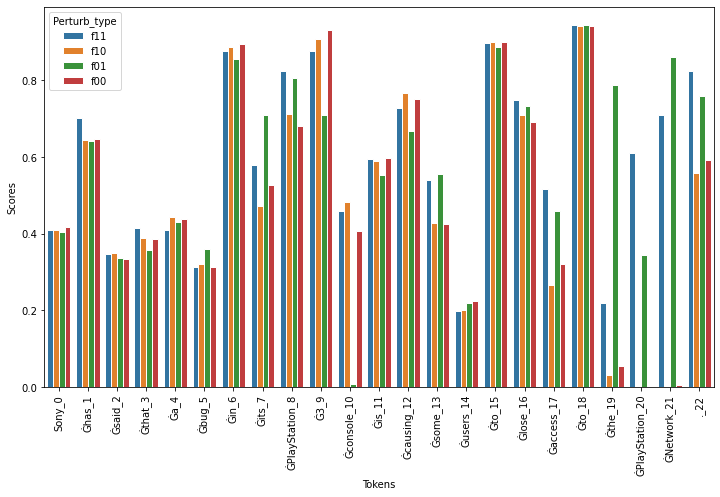


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like down

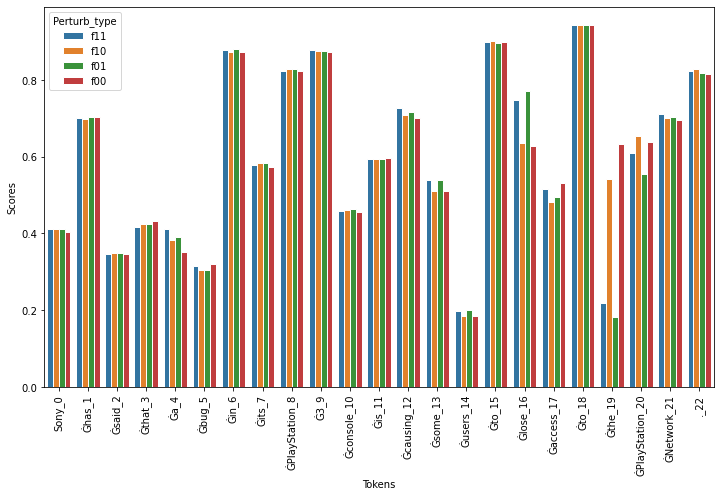


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download software or vi

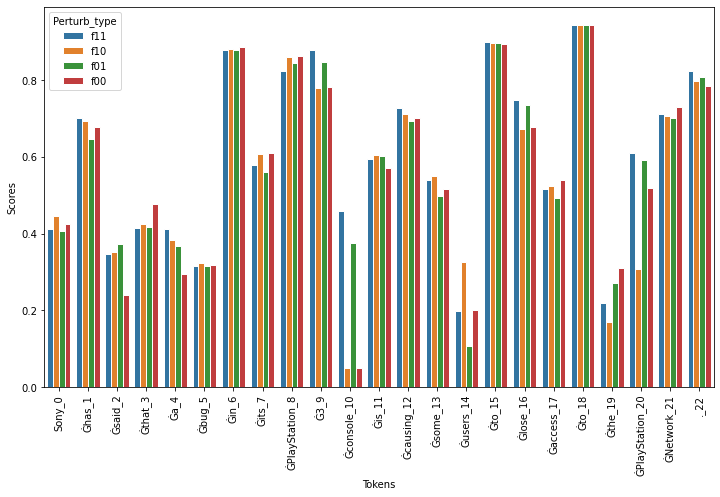


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like do

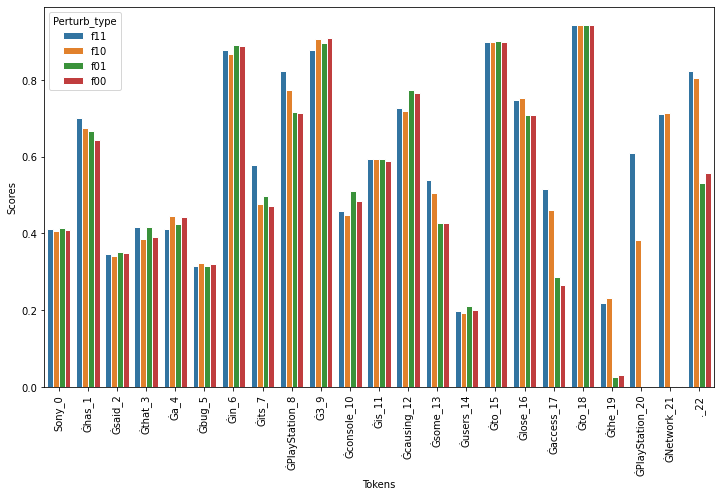


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their console for the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download so

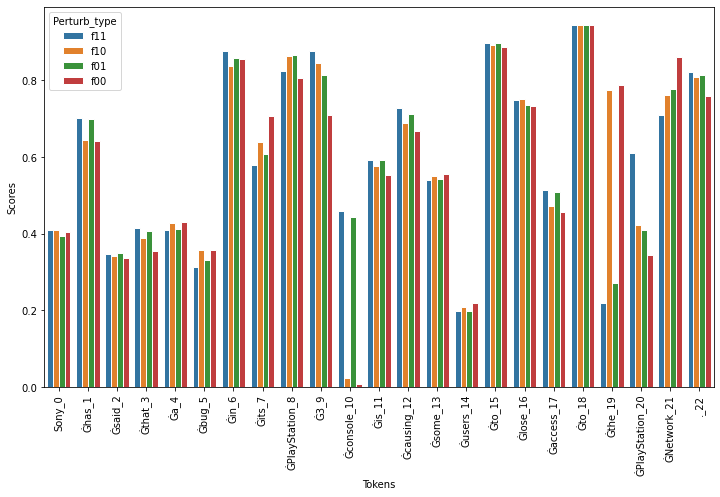


 Masked input (f10): The problem is affecting people using the older versions of the PlayStation 3, called the "Fat" model.The problem isn't affecting the newer PS3 Slim systems that have been on sale since September last year.Sony have also said they are aiming to have the problem fixed shortly but is advising some users to avoid using their the time being."We hope to resolve this problem within the next 24 hours," a statement reads. "In the meantime, if you have a model other than the new slim PS3, we advise that you do not use your PS3 system, as doing so may result in errors in some functionality, such as recording obtained trophies, and not being able to restore certain data."We believe we have identified that this problem is being caused by a bug in the clock functionality incorporated in the system."The PlayStation Network is used by millions of people around the world.It allows users to play their friends at games like Fifa over the internet and also do things like download so

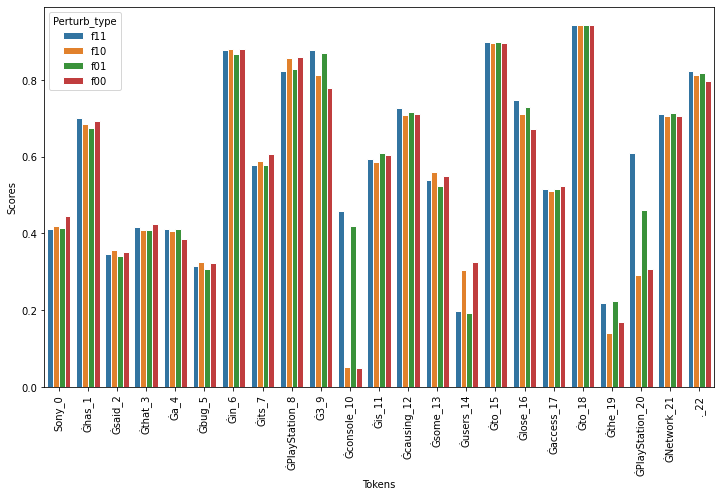

Partition explainer: 2it [01:08, 34.49s/it]                                                                            


In [18]:
shap_values = explainer(dataset['document'][0:1],model_kwargs=f_kwargs)

In [12]:
shap.plots.text(shap_values[0])

,,The,problem,is,affecting,people,using,the,older,versions,of,the,PlayStation,3,",",called,the,"""",Fat,"""",model,.,The,problem,isn,'t,affecting,the,newer,PS,3,Slim,systems,that,have,been,on,sale,since,September,last,year,.,Sony,have,also,said,they,are,aiming,to,have,the,problem,fixed,shortly,but,is,advising,some,users,to,avoid,using,their,console,for,the,time,being,".""",We,hope,to,resolve,this,problem,within,the,next,24,hours,",""",a,statement,reads,.,"""",In,the,meantime,",",if,you,have,a,model,other,than,the,new,slim,PS,3,",",we,advise,that,you,do,not,use,your,PS,3,system,",",as,doing,so,may,result,in,errors,in,some,functionality,",",such,as,recording,obtained,trophies,",",and,not,being,able,to,restore,certain,data,".""",We,believe,we,have,identified,that,this,problem,is,being,caused,by,a,bug,in,the,clock,functionality,incorporated,in,the,system,".""",The,PlayStation,Network,is,used,by,millions,of,people,around,the,world,.,It,allows,users,to,play,their,friends,at,games,like,Fifa,over,the,internet,and,also,do,things,like,download,software,or,visit,online,stores,.,Ċ,
Sony,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.035,0.035,0.035,0.035,0.035,0.035,0.035,0.035,-0.003,-0.003,-0.003,-0.003,-0.003,-0.003,-0.003,-0.003,0.003,0.003,0.003,0.003,-0.005,-0.005,-0.008,-0.008,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.001,-0.001,0.003,0.004,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.002,0.002,0.002,0.002,-0.001,-0.001,-0.001,-0.001,0.011,-0.005,-0.005,0.004,0.001,0.001,0.001,0.001,-0.001,-0.001,-0.001,-0.001,-0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
has,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,-0.005,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.006,0.006,0.006,0.006,-0.003,-0.003,-0.008,-0.008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.005,0.008,0.008,0.008,0.008,0.004,0.004,-0.001,0.005,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.004,0.004,0.004,0.004,-0.005,-0.005,-0.005,-0.005,-0.021,0.035,0.009,0.002,0.01,0.01,0.01,0.01,-0.001,-0.001,-0.001,-0.001,-0.001,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002
said,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,0.015,0.015,0.015,0.015,0.024,0.024,0.016,0.016,0.002,0.002,0.002,0.002,0